# Multi-task Training with Hugging Face Transformers and NLP

### Or: A recipe for multi-task training with Transformers' Trainer and NLP datasets



Hugging Face has been building a lot of exciting new NLP functionality lately. The newly released [NLP](https://github.com/huggingface/nlp) provides a wide coverage of task data sets and metrics, as well as a simple interface for processing and caching the inputs extremely efficiently. They have also recently introduced a [Trainer](https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py) class to the Transformers library that handles all of the training and validation logic.

However, one feature that is not currently supported in Hugging Face's current offerings is *multi-task training*. While there has been some discussion about the best way to support multi-task training ([1](https://github.com/huggingface/transformers/issues/4340), [2](https://github.com/huggingface/nlp/issues/217)), the community has not yet settled on a convention for doing so. Multi-task training has been shown to improve task performance ([1](https://www.aclweb.org/anthology/P19-1441/), [2](https://arxiv.org/abs/1910.10683)) and is a common experimental setting for NLP researchers.

In this Colab notebook, we will show how to use both the new NLP library as well as the Trainer for a **multi-task** training scheme.

So let's get started!

## Library setup

First up, we will install the *NLP* and *Transformers* libraries. 

<font color='red'>**Note: After running the following cell, you will need to restart your runtime for the installation to work properly.**</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install git+https://github.com/huggingface/nlp
!pip install --quiet transformers==2.11.0
!pip install --quiet nlp==0.2.0
!pip install --quiet datasets

     |████████████████████████████████| 674 kB 13.7 MB/s 
     |████████████████████████████████| 5.6 MB 89.2 MB/s 
     |████████████████████████████████| 1.2 MB 85.1 MB/s 
     |████████████████████████████████| 895 kB 90.7 MB/s 
     |████████████████████████████████| 857 kB 14.0 MB/s 
     |████████████████████████████████| 306 kB 14.6 MB/s 
     |████████████████████████████████| 243 kB 68.2 MB/s 
     |████████████████████████████████| 1.1 MB 87.0 MB/s 
     |████████████████████████████████| 133 kB 104.2 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 192 kB 80.8 MB/s 
     |████████████████████████████████| 271 kB 89.2 MB/s 
     |████████████████████████████████| 160 kB 95.4 MB/s 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import transformers
import nlp
# from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

import json
import tqdm

## Fetching our data

To showcase our multi-task functionality, we will choose tasks of different formats:

* STS-B: A two-sentece textual similarity scoring task. (Prediction is a real number between 1 and 5)
* RTE: A two-sentence natural language entailment task. (Prediction is one of two classes)
* Commonsense QA: A multiple-choice question-answering task. (Each example consists of 5 seperate text inputs, prediction is which one of the 5 choices is correct)

In particular, notice that unlike STS-B and RTE, Commonsense QA consists of feeding *multiple* inputs into the transformer model. Many other tasks have weirder formats too, so our setup needs to be flexible enough to accomodate very different kinds of tasks.

Now, actually getting the task data is super simple. We can simply call the `nlp.load_dataset` method, which automatically downloads the data and prepares it for use.

-----
## Previously trained files

In [ ]:
# semeval data links + scores
df_train = pd.read_csv('/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/train_v2.csv', index_col='pair_id')
# ranked data 
ranked = json.load(open(file='/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/filtered_docs_v2_multilingual_append.json'))
# reform the data
data = dict()
for index, example in enumerate(ranked.values()):
  print(example['index_a'], example['doc_a'])
  text1 = '. '.join(example['doc_a'])
  text2 = '. '.join(example['doc_b'])
  pair_id = '_'.join([example['index_a'], example['index_b']])
  overall = df_train.loc[pair_id, 'Overall']
  if isinstance(overall, pd.core.series.Series):
    overall = overall.iloc[0]

  data[index] = {'sentence1': text1, 'sentence2': text2, 'label': overall, 'idx': index}
# saving the data 
df_ranked = pd.DataFrame.from_dict(data, orient='index')

In [ ]:
df_ranked = df_ranked[(df_ranked.sentence1 != "") & (df_ranked.sentence2 != "")]

In [ ]:
df_ranked

,sentence1,sentence2,label,idx
0,police west virginia say suspect drunken drive...,haitian president jovenel moïse break traditio...,4.000000,0
1,share pin shares news room guyana three person...,berlin fire zoo western germany first minute k...,3.666667,1
2,want say resolution think jinx right video wil...,us president say response riot pro iranian dem...,2.333333,2
3,zomato tuesday announce acquire uber food deli...,report google boston consulting group bcg reve...,2.000000,3
4,india approve third lunar mission month last o...,india plan make fresh attempt land unmanned mi...,1.250000,4
...,...,...,...,...
4522,سعر الدولار اليوم شهد تراجعا جديدا أمام الجنيه...,سعر الدولار اليوم الثلاثاء سعر الدولار اليوم ا...,1.000000,4522
4523,أعلن الدكتور أيمن مختار محافظ الدقهلية ضرورة ف...,قال الدكتور أيمن مختار محافظة الدقهلية إنه تم ...,1.000000,4523
4524,طرطوس سانا كثرة ينابيع قرية بحوي وجمال طبيعتها...,طرطوس سانا تمتاز بلدة النيحا بموقعها والغابات ...,4.000000,4524
4525,بوابة أخبار اليوم الإلكترونية. إيمان إسحاق أمي...,أشاد اللواء أشرف عطيه محافظ اسوان بحملات التطه...,2.000000,4525


In [ ]:
df_ranked.to_csv('../dataset/ranked_train_v2_append.csv', index=False)

In [ ]:
# train-test-validation split
main_df, test_df = train_test_split(df_ranked, test_size=0.1)
train_df, validation_df = train_test_split(main_df, test_size=0.1)
print(train_df.shape, test_df.shape, validation_df.shape)
# generate Dataset
# train_dataset = Dataset.from_pandas(train_df)
# test_dataset = Dataset.from_pandas(test_df)
# validation_dataset = Dataset.from_pandas(validation_df)
# reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
# save files to loc
train_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/text_rank_training_files/multilingual_text_rank/append_summary/train.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/text_rank_training_files/multilingual_text_rank/append_summary/test.csv", index=False)
validation_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/text_rank_training_files/multilingual_text_rank/append_summary/validation.csv", index=False)

(3640, 4) (450, 4) (405, 4)


In [ ]:
train_df

,sentence1,sentence2,label,idx
0,die jüngst vom bundesrat beschlossenen lockeru...,es bestehe die gefahr dass die fälle nächster ...,1.0,2114
1,time decide new year resolution many people ne...,read choice galore financial advisor pick one ...,4.0,929
2,researcher study diet captivity enhance surviv...,father one tell garda rape officer mother sist...,4.0,724
3,das ist eine ganze menge lesestoff für die jur...,legal general investment management lgim expan...,4.0,2707
4,article ultimate human idiocy earth muslim sui...,article humanism help people humanism never en...,4.0,536
...,...,...,...,...
3635,así se informó desde la secretaría de desarrol...,válido aclarar día marzo próximo feriado igual...,4.0,3257
3636,par david lawder et andrea shalal washington r...,la croissance chinoise sera supérieure à pour ...,3.0,4241
3637,frankfurt dpa afx der corona pandemie ist das ...,berlin dpa afx die deutschland wegen der coron...,4.0,2376
3638,أكد الإعلامي أحمد شوبير نائب رئيس اتحاد الكرة ...,أكد الإعلامي أحمد شوبير أنه رفض الترشح على منص...,4.0,4313


In [ ]:
# path_to_fnc_data = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/external_data/FNC_1/fnc_1.csv"
# fnc_df = pd.read_csv(path_to_fnc_data)
# # drop Body ID 
# fnc_df.drop(['Body ID'], axis=1, inplace=True)
# # add index column
# fnc_df['idx'] = np.arange(fnc_df.shape[0])
# # rearrange columns
# fnc_df = fnc_df[['Headline', 'articleBody', 'Stance', 'idx']]
# # convert classes to categorical values
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(fnc_df['Stance'])
# fnc_df['Stance']=le.transform(fnc_df['Stance'])
# # save data
# fnc_df.to_csv(path_to_fnc_data, index=False)
# # split dataset
# path_to_dir = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/external_data/FNC_1/Data"
# train, test = train_test_split(fnc_df, test_size=0.1)
# train, validation = train_test_split(train, test_size=0.1)
# train.to_csv(f"{path_to_dir}/train.csv", index=False)
# test.to_csv(f"{path_to_dir}/test.csv", index=False)
# validation.to_csv(f"{path_to_dir}/validation.csv", index=False)

-----
## Processing

In [ ]:
# paths to semeval dataset
path_to_longform_textrank_data = "../dataset/semeval/multilingual/"
path_to_train = f"{path_to_longform_textrank_data}train.csv"
path_to_test = f"{path_to_longform_textrank_data}test.csv"
path_to_validation = f"{path_to_longform_textrank_data}final_test_v1.csv"

# paths to fnc dataset
path_to_fnc_data = "../dataset/FNC/"
path_to_fnc_train = f"{path_to_fnc_data}train_v2.csv"
path_to_fnc_validation = f"{path_to_fnc_data}validation.csv"
path_to_fnc_test = f"{path_to_fnc_data}test_v2.csv"

In [ ]:
dataset_dict = {
  "semeval": load_dataset('csv', data_files={
      'train': path_to_train,
      'validation': path_to_validation,
      'test': path_to_test,
  }),
}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7768e19ba8d56487/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

remove all the extra fields and phase data from rte and rename the fields.

In [ ]:
dataset_dict

{'semeval': DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3571
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 397
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 441
    })
})}

We can show one example from each task.

In [ ]:
for task_name, dataset in dataset_dict.items():
    print(task_name)
    print(dataset_dict[task_name]["train"][0])
    print()

semeval
{'sentence1': 'schweden erlebt seit vergangenen jahr rapiden anstieg vorsätzlich herbeigeführten explosionen region stockholm schon mehrere gegeben. personen hätten verlassen müssen uppsala rund kilometer nördlich gab laut widstrand detonation. kräftigsten explosionen bisher region gehabt sagte stockholms polizeichef erik widstrand nachmittag pressekonferenz. gebäude stockholmer stadtteil östermalm wurden dabei nacht montag fahrzeuge teils stark beschädigt. handle glücksfall dabei niemand verletzt wurde. haus sei evakuiert worden teilte polizei. augenzeugenberichten zufolge explosion kilometerweit entfernt teilen stockholms hören', 'sentence2': 'stadt wochen zuvor bereits mehrere sprengsätze detoniert deren hintergründe polizei bandenmilieu vermutet. sei derzeit unklar explosion haus davor ereignet sagte polizeisprecherin zeitung aftonbladet. handgranaten explosionen schulen nachtclubs aktuellen fall gingen ersten notrufe demnach uhr polizei. bilder schwedischen medien zeigen d

In [ ]:
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict):
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models. 

        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task_name],
            )
            if shared_encoder is None:
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict)

    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        print(model_class_name)
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        elif model_class_name.startswith("XLMRoberta"):
            return "roberta"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        return self.taskmodels_dict[task_name](**kwargs)



As described above, the `MultitaskModel` class consists of only two components - the shared "encoder", a dictionary to the individual task models. Now, we can simply create the corresponding task models by supplying the invidual model classes and model configs. We will use Transformers' AutoModels to further automate the choice of model class given a model architecture (in our case, let's use `roberta-base`).

In [ ]:
model_name = "xlm-roberta-base"
multitask_model = MultitaskModel.create(
    model_name=model_name,
    model_type_dict={
        "fnc": transformers.AutoModelForSequenceClassification,
        "semeval": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "fnc": transformers.AutoConfig.from_pretrained(model_name, num_labels=4),
        "semeval": transformers.AutoConfig.from_pretrained(model_name, num_labels=1),
    },
)

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp2zbujlep


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json in cache at /root/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /root/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:transformers.configuration_utils:Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bo

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://cdn.huggingface.co/xlm-roberta-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/5cbeb972feded79b927818648bf14dc71b7810cda88c8c971a9d45c0dab901ec.aeeaca90954dc20ffa2909de722cfbfd455c5bb16d480c5bdf6d7fe79c68c267
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/5cbeb972feded79b927818648bf14dc71b7810cda88c8c971a9d45c0dab901ec.aeeaca90954dc20ffa2909de722cfbfd455c5bb16d480c5bdf6d7fe79c68c267
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/xlm-roberta-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/5cbeb972feded79b927818648bf14dc71b7810cda88c8c971a9d45c0dab901ec.aeeaca90954dc20ffa2909de722cfbfd455c5bb16d480c5bdf6d7fe79c68c267
INFO:transformers.modeling_utils:Weights of XLMRobertaForSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

XLMRobertaForSequenceClassification


INFO:transformers.modeling_utils:Weights of XLMRobertaForSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
INFO:transformers.modeling_utils:Weights from pretrained model not used in XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']


XLMRobertaForSequenceClassification


To confirm that all three task-models use the same encoder, we can check the data pointers of the respective encoders. In this case, we'll check that the word embeddings in each model all point to the same memory location.

In [ ]:
if model_name.startswith("roberta-"):
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["fnc"].roberta.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["semeval"].roberta.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Exercise for the reader: add a check for other model architectures =)")

Exercise for the reader: add a check for other model architectures =)


## Processing our task data

We have created a dictionary of NLP datasets above, but we need to do a little more work to convert the respective task data into model inputs.

We'll start by first getting the tokenizer corresponding to our model.

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /root/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:transformers.configuration_utils:Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-sentencepiece.bpe.model in cache at /root/.cache/torch/transformers/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-sentencepiece.bpe.model from cache at /root/.cache/torch/transformers/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed


In [ ]:
max_length = 128

def convert_to_semeval_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    print(type(inputs[0][0]))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=512, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_fnc_features(example_batch):
    inputs = list(zip(example_batch['Headline'], example_batch['articleBody']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["Stance"]
    return features


convert_func_dict = {
    "fnc": convert_to_fnc_features,
    "semeval": convert_to_semeval_features,
}

Now that we have defined the above functions, we can use `dataset.map` method available in the NLP library to apply the functions over our entire datasets. The NLP library that handles the mapping efficiently and caches the features.

In [ ]:
columns_dict = {
    "fnc": ['input_ids', 'attention_mask', 'labels'],
    "semeval": ['input_ids', 'attention_mask', 'labels'],
}

features_dict = {}
for task_name, dataset in dataset_dict.items():
    print(u"\u2192", task_name)
    features_dict[task_name] = {}
    for phase, phase_dataset in dataset.items():
        features_dict[task_name][phase] = phase_dataset.map(
            convert_func_dict[task_name],
            batched=True,
            load_from_cache_file=False,
        )
        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))
        features_dict[task_name][phase].set_format(
            type="torch", 
            columns=columns_dict[task_name],
        )
        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))

→ semeval


  0%|          | 0/4 [00:00<?, ?ba/s]

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
semeval train 3571 3571
semeval train 3571 3571


  0%|          | 0/1 [00:00<?, ?ba/s]

<class 'str'>
semeval validation 397 397
semeval validation 397 397


  0%|          | 0/1 [00:00<?, ?ba/s]

<class 'str'>
semeval test 441 441
semeval test 441 441


As a recap:

* We have created our multi-task model by fusing several single-task Transformer models
* We have created a (cached) dictionary of featurized inputs for each of our tasks, using NLP dataset

Next up, we need to 

1. Set up our data loading
2. Set up our Trainer 
3. Start training!

## Preparing a multi-task data loader and Trainer

In [ ]:
import dataclasses
from torch.utils.data.dataloader import DataLoader
from transformers.training_args import is_tpu_available
from transformers.trainer import get_tpu_sampler
from transformers.data.data_collator import DataCollator, InputDataClass, DefaultDataCollator
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict


class NLPDataCollator(DataCollator):
    """
    Extending the existing DataCollator to work with NLP dataset batches
    """
    def collate_batch(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        if isinstance(first, dict):
          # NLP data sets current works presents features as lists of dictionary
          # (one per example), so we  will adapt the collate_batch logic for that
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          return batch
        else:
          # otherwise, revert to using the default collate_batch
          return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """
    def to(self, device):
        return self


class DataLoaderWithTaskname:
    """
    Wrapper around a DataLoader to also yield a task name
    """
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    """
    Data loader that combines and samples from multiple single-task
    data loaders.
    """
    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) 
            for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
        """
        For each batch, sample a task, and yield a batch from the respective
        task Dataloader.

        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])    

class MultitaskTrainer(transformers.Trainer):

    def get_single_train_dataloader(self, task_name, train_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        if is_tpu_available():
            train_sampler = get_tpu_sampler(train_dataset)
        else:
            train_sampler = (
                RandomSampler(train_dataset)
                if self.args.local_rank == -1
                else DistributedSampler(train_dataset)
            )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )

        if is_tpu_available():
            data_loader = pl.ParallelLoader(
                data_loader, [self.args.device]
            ).per_device_loader(self.args.device)
        return data_loader

    def get_train_dataloader(self):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each 
        task Dataloader
        """
        return MultitaskDataloader({
            task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()
        })

## Time to train!

Okay, we have done all the hard work, now it is time for it to pay off. We can now simply create our `MultitaskTrainer`, and start training! 

(This takes about ~45 minutes for me on Colab, but it will depend on the GPU you are allocated.)

In [ ]:
train_dataset = {
    task_name: dataset["train"] 
    for task_name, dataset in features_dict.items()
}
validation_dataset = {
    task_name: dataset["validation"]
    for task_name, dataset in features_dict.items()
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/train_models/mtl-sentiment-analysis-stance-detection/models/multitask_model_test",
        # overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=5,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=8,  
        save_steps=4300,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)
trainer.train()

INFO:transformers.training_args:PyTorch: setting up devices
INFO:transformers.trainer:You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.
INFO:transformers.trainer:***** Running training *****
INFO:transformers.trainer:  Num examples = 3571
INFO:transformers.trainer:  Num Epochs = 5
INFO:transformers.trainer:  Instantaneous batch size per device = 8
INFO:transformers.trainer:  Total train batch size (w. parallel, distributed & accumulation) = 8
INFO:transformers.trainer:  Gradient Accumulation steps = 1
INFO:transformers.trainer:  Total optimization steps = 2235


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/447 [00:00<?, ?it/s]

Iteration:   0%|          | 0/447 [00:00<?, ?it/s]

{"loss": 0.22035100348060951, "learning_rate": 7.762863534675615e-06, "epoch": 1.1185682326621924, "step": 500}


Iteration:   0%|          | 0/447 [00:00<?, ?it/s]

{"loss": 0.16245536054670812, "learning_rate": 5.525727069351231e-06, "epoch": 2.237136465324385, "step": 1000}


Iteration:   0%|          | 0/447 [00:00<?, ?it/s]

{"loss": 0.12050523469410837, "learning_rate": 3.2885906040268462e-06, "epoch": 3.3557046979865772, "step": 1500}


Iteration:   0%|          | 0/447 [00:00<?, ?it/s]

{"loss": 0.11017777719907462, "learning_rate": 1.051454138702461e-06, "epoch": 4.47427293064877, "step": 2000}


INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2235, training_loss=0.14922566017588096)

All done! Now, we can evaluate our multi-task model on all three tasks. In this case, we can simply use single-task data loaders, since we are evaluating each task individually.

We will use the (private) `_prediction_loop` method from the Trainer.

In [ ]:
eval_dataloader = DataLoaderWithTaskname(
    "semeval",
    trainer.get_eval_dataloader(eval_dataset=features_dict["semeval"]["train"])
)
print(eval_dataloader.data_loader.collate_fn)
pred_dict = trainer._prediction_loop(
    eval_dataloader, 
    description=f"Validation: {task_name}",
)

INFO:transformers.trainer:***** Running Validation: semeval *****
INFO:transformers.trainer:  Num examples = 3571
INFO:transformers.trainer:  Batch size = 8


<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f53174a14d0>>


Validation: semeval:   0%|          | 0/447 [00:00<?, ?it/s]

In [ ]:
# Test-set Evalute STS-B
nlp.load_metric('glue', name="stsb").compute(
    pred_dict.predictions.flatten(),
    pred_dict.label_ids,
)

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue
INFO:nlp.load:Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py to /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68/glue.py
INFO:nlp.load:Couldn't find dataset infos file at https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glu

{'pearson': 0.9730807409686485, 'spearmanr': 0.9481045420427802}

In [ ]:
index = [item['idx'] for item in dataset_dict['semeval']['test']]
bad_pred = []
for pred, actual, id in zip(pred_dict.predictions.flatten(), pred_dict.label_ids, index):
    if (abs(pred - actual) > 1):
        bad_pred.append(id)

In [ ]:
test_df = pd.read_csv(path_to_test, index_col='idx')

In [ ]:
test_df.loc[bad_pred]

,sentence1,sentence2,label
idx,,,
3271,agregó proyecto modernización equipos mediante...,total familias caficultoras tilarán abangares ...,1.000000
3598,açıklamada görüşlerine yer verilen kadın güreş...,avrupa şampiyonası nda milli takımın başarılı ...,1.000000
3028,sexta vez muti encargue conducir famoso recita...,cumpleaños beethoven si cumpleaños musical ani...,3.000000
988,residents south coast towns like nelligen rose...,herald spoke range visitors anxious leave give...,1.333333
1294,hearing reading hatred towards jewish communit...,warning image may disturbing viewers federal h...,2.333333
...,...,...,...
3604,edinilen bilgilere göre cafer doğan hasan doğa...,aspiratör bacasındaki yavru kuş telef olmaktan...,3.000000
283,like grand mega trend next years pricing weigh...,fmcg maybe much telecom may good proxy consump...,3.000000
2826,aktueller stand uhr analyse weiteren verbreitu...,date confirmed cases covid st kitts nevis. inc...,3.000000


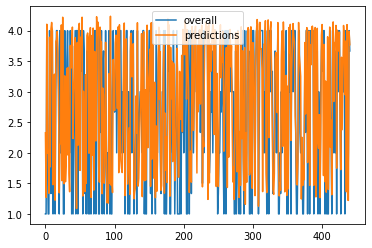

In [ ]:
line1, = plt.plot(pred_dict.label_ids, label="overall")
line2, = plt.plot(pred_dict.predictions.flatten(), label="predictions")
leg = plt.legend(loc='upper center')
plt.show()

In [ ]:
preds_dict = {}
# for task_name in ["rte", "stsb", "commonsense_qa"]:
for task_name in ["fnc", "semeval"]:
    eval_dataloader = DataLoaderWithTaskname(
        task_name,
        trainer.get_eval_dataloader(eval_dataset=features_dict[task_name]["validation"])
    )
    print(eval_dataloader.data_loader.collate_fn)
    preds_dict[task_name] = trainer._prediction_loop(
        eval_dataloader, 
        description=f"Validation: {task_name}",
    )

INFO:transformers.trainer:***** Running Validation: fnc *****
INFO:transformers.trainer:  Num examples = 5647
INFO:transformers.trainer:  Batch size = 8


<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f1f66212790>>


Validation: fnc:   0%|          | 0/706 [00:00<?, ?it/s]

INFO:transformers.trainer:***** Running Validation: semeval *****
INFO:transformers.trainer:  Num examples = 397
INFO:transformers.trainer:  Batch size = 8


<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f1f66212790>>


Validation: semeval:   0%|          | 0/50 [00:00<?, ?it/s]

Now that we have all the predictions, let's go ahead and score them. The NLP library also has built-in metrics for the GLUE tasks (which includes STS-B and RTE), but not for Commonsense QA. Thankfully, Commonsense QA's evaluation metric is simple accuracy, which we can compute easily.

In [ ]:
# Evalute RTE
nlp.load_metric('glue', name="rte").compute(
    np.argmax(preds_dict["fnc"].predictions, axis=1),
    preds_dict["fnc"].label_ids,
)

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue
INFO:nlp.load:Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py to /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68/glue.py
INFO:nlp.load:Couldn't find dataset infos file at https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glu

{'accuracy': 0.970072604922968}

In [ ]:
# # Evalute STS-B 
# nlp.load_metric('glue', name="stsb").compute(
#     preds_dict["stsb"].predictions.flatten(),
#     preds_dict["stsb"].label_ids,
# )

In [ ]:
# Evalute Semeval+-
nlp.load_metric('glue', name="stsb").compute(
    preds_dict["semeval"].predictions.flatten(),
    preds_dict["semeval"].label_ids,
)

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue
INFO:nlp.load:Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py to /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68/glue.py
INFO:nlp.load:Couldn't find dataset infos file at https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glu

{'pearson': 0.6833074171782954, 'spearmanr': 0.6857551478232559}

In [ ]:
# Evalute Commonsense QA
# np.mean(
#     np.argmax(preds_dict["commonsense_qa"].predictions, axis=1)
#     == preds_dict["commonsense_qa"].label_ids
# )

You should expect scores of approximately:

* RTE: ~0.74
* STS-B: ~0.89/0.89
* Commonsense QA: ~0.60

These aren't award winning scores, nor are our tasks chosen for multi-task training synergy, but hopefully we have demonstrated how to do multi-task training with some of Hugging Face's latest offerings!

# An advertisement: Come check out jiant!

While the above recipe works, we saw what some of the frictions were: handling multi-task data loading, coercing the Trainer to work with multi-task inputs, and handling the featurization for each of the tasks.

If you are interested in more streamlined multi-task (or even single-task) fine-tuning work, we are building [jiant](https://jiant.info/), an NLP research-oriented library, built directly on the Transformers, where multi-task training is a first-class feature. `jiant` aims to facilitate cutting-edge NLP transfer learning research through broad task coverage and modular components, and we highly recommend using `jiant` for streamlined multi-task training workflows.

(If you've previously worked with `jiant`, we are currently undertaking [a complete rewrite](https://github.com/jiant-dev/jiant) to better support current research needs and engineering workflows.)

Click [here](https://jiant.info/) to learn more, or attend our system demo presentation at [ACL 2020](https://acl2020.org/program/accepted/#system-demonstrations).